# Deep ANN - Sharpe ratio

#### - I have coded below my own deep neural network to predict Long or Short positions in daily. 
#### - I used a BTC dataset from Binance in daily and added technical indicators from the Talib library. 
#### - The loss function is a Sharpe ratio to maximize.

In [1]:
# Manipulate data and visualize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Add Talib indicators
import talibfunction as TF
import talib

# Split the data set
from sklearn.model_selection import train_test_split

# Scaling
from sklearn.preprocessing import StandardScaler

##### We start by defining the functions required for the deep neural network.

In [2]:
# Initialize the parameters
def initialisation(
    dimensions
):  # dimensions represents a list with the number of neurons per layer e.g. [2, 32, 16, 1] attention 2 would be the number of inputs not neurons, the first layer will be 32

    parametres = {}  # set the parameters of each layer
    C = len(
        dimensions
    )  # number of layers (actually remove one layer as the input is not really a layer)

    np.random.seed(1)

    for c in range(1, C):  # initialize the parameters of each layer randomly
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[
            c -
            1]) 

    return parametres

In [3]:
# Forward propagation
def forward_propagation(X, parametres):  # Calculation of activations

    activations = {
        'A0': X
    }  # dict of activations with already A0 associated with the matrix X

    C = len(
        parametres)  # in the dict parameters we find the length of our network

    for c in range(
            1, C + 1
    ):  # to calculate Z1, A1, Z2, A2, etc . C will be the final layer of the network (C+1 not to exclude C)
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)])

        activations['A' + str(c)] = np.tanh(
            Z)  # all activations are passed on to the dict activation

    return activations

In [4]:
# Calculating Returns on investment
def returns(Ft, x, M):  # Ft = all the positions, x = obs
    rets = Ft * x[M+1:, 0].reshape(x[M+1:, 0].shape[0], 1)  # given all the returns for each obs

    return rets

In [5]:
# Update of network parameters (weights)
def update(gradients, parametres,
           learning_rate):

    C = len(parametres)  # length of the network

    for c in range(1, C + 1):  # to update the parameters at each iteration
        parametres['W' + str(c)] = parametres[
            'W' + str(c)] + learning_rate * gradients['dW' + str(c)]

    return parametres

In [6]:
# To calculate the predictions in float
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres)
    Af = activations['A' + str(C)]
    return Af[0][0]

In [7]:
# New prediction on new data set : in order to prepare the data to make predictions
def new_prediction(data_set, y, parametres, M):  # M = sequence_number

    Ft_pred_test = np.zeros(len(data_set)).astype(float)
    for it in range(M, len(data_set)):  # for each sequences of size M

        # Flatten the array to compute position if we have more than one seq
        xt = data_set.T[:, it - M:it]

        mix = y[it - M:it]  # add the actual positions of the previous days
        xt = np.vstack((xt, mix))
        xt = xt.flatten(order='F')  # flatten by column
        xt = np.hstack(
            (xt, Ft_pred_test[it - 1]))  # add Ft of t-1 for last day (column)
        xt = xt.reshape(xt.shape[0], 1)

        Ft_pred_test[it] = predict(xt, parametres)

    return Ft_pred_test  # return pred

In [8]:
# Convert the predictions into 1, -1, 0 depending on the threshold you want
def convert_prediction(predictions, upper_threshold, lower_threshold):
    transform_pos = []
    for i in predictions:
        if i > upper_threshold:
            transform_pos.append(1)
        elif i < lower_threshold:
            transform_pos.append(-1)
        else:
            transform_pos.append(0)
    transform_pos = np.array(transform_pos)
    
    return transform_pos

In [9]:
# Find the returns of our predictions
def return_pred(predictions, data, M):
    
    return (predictions[M:] * data[M:, 0].reshape(data[M:, 0].shape[0], 1).T).T

In [10]:
# Implementation of the neural network in a single function
def deep_neural_network(x_train,
                        y_train,
                        x_val,
                        y_val,
                        x_train_pct_change,
                        hidden_layers=(32, 16, 8),
                        learning_rate=0.1,
                        epochs=2000,
                        sequences_number=1):

    # How many days we give to predict
    M = sequences_number

    # Train set
    X = x_train.T
    y = y_train.T

    # Test set
    X_val = x_val.T  # This one is not necessary but is kept for form
    Y_val = y_val.T

    # Initialisation parametres
    dimensions = list(hidden_layers)
    dimensions.insert(
        0, X.shape[0]*M + M + 1
    )  # add to the beginning of the list the number of input sequences to make a prediction, + M because we add Ft at t-1 for each day
    dimensions.append(
        1) # addition of the prediction dimension, here a short or long prediction
    np.random.seed(1)

    # Randomly initialize weights
    parametres = initialisation(dimensions)  # initialization of parameters

    # Total number of weights
    C = len(parametres) # means that there is C layers of parameters. Ex : W1, W2, W3 ...

    # Variables to store history (accuracy and ratios)
    training_history = np.zeros(
        (int(epochs), 2))  # table to contain accuracy of train
    ratios = np.zeros(
        epochs)  # store ratio over time, one sharpe/sortino ratio by epoch

    # Variable to keep the new val accuracy and add it to the history
    new_val_acc = 0

    # Variable to keep the best val accuracy and epoch found
    best_val_acc = 0
    best_epoch_val = 0

    # Variable to save the best parameters of the model
    best_params = parametres # first our best params are simply the init parametres

    # Transform y if we want to use it to do the predictions
    y_gd = np.insert(y, 0, 1) # y for the gradient descent to not have data leakage, 1 by default
    y_gd = y_gd.astype(np.float)  # transform elements to float
    y = y[0].astype(np.float)

    # Same thing with Y_val (validation set) to compute after the accuracy
    y_val_gd = np.insert(Y_val, 0, 1) # y_val for the gradient descent in new_pred to not have data leakage, 1 by default
    y_val_gd = y_val_gd.astype(np.float)  # transform elements to float
    Y_val = Y_val[0].astype(np.float)
    step_val = round(
        1 / (len(x_val) / (len(x_train) + len(x_val)))
    )  # to find out how much data is displayed accuracy for the validation data

    # Forward propagation
    for i in tqdm(range(epochs)):

        first_FP = True # first forward prop
        Ft = np.zeros(len(X.T))

        for it in range(M, len(X.T)):  # for each sequences of size M => forward propagation. We left the last xt because we do not have his prediction since it is the last one

            # input X_train
            xt = X[:, it - M:it]

            mix = y_gd[it -
                       M:it]  # add the actual positions of the previous days
            xt = np.vstack((xt, mix))
            xt = xt.flatten(order='F')  # flatten by column
            xt = np.hstack(
                (xt, Ft[it - 1]))  # add Ft of t-1 for last day (column)
            xt = xt.reshape(xt.shape[0], 1)

            # Do the forward propagation for each sequence
            activations = forward_propagation(xt, parametres)

            val_pred = activations['A' + str(C)] # predicted value at network output
            Ft[it] = val_pred  # value between -1 and 1, if between -1 and 0 => short, 0 neutral, 0 and 1 => long

            # Prepare the final dictionary which will contain all activations
            if first_FP:
                final_activations = activations
                first_FP = False
            else:
                for k in activations.keys():
                    final_activations[k] = np.concatenate(
                        (final_activations[k], activations[k]), axis=1)

        # Ft contains the predictions of the positions
        Ft = Ft.reshape(Ft.shape[0], 1)
        Ft = Ft[
            M:
            -1, :] # do not keep first pred that is equal to 0 and -1 to have the same number of predictions as final_activations[f'A{c}'][:, 1:]

        # Do not keep first pred that is equal to 0
        final_activations['A0'] = final_activations[
            'A0'][:, 1:]

        for c in range(1, C + 1): # same thing but for each layers
            final_activations[f'A{c}'] = final_activations[f'A{c}'][:, 1:] # have to drop the first prediction

        # Back propagation
        gradients = {}
        for c in reversed(range(1, C + 1)): # each layers
            #print(f'A{c}') to know on which layer we are
            grad_per_layers = []

            all_returns = returns(
                final_activations[f'A{c}'].T, x_train_pct_change,
                M)  # all the returns for each obs of the layer

            T = len(all_returns)

            for r in range(
                    len(all_returns.T)
            ):  # look at the return from each neuron in the layer to update the neuron weights
                #print(f'neuron{r}') to know on which neuron we are

                R = np.array([all_returns[:, r]]).T # convert the return on invest. according to the neuron into array

                # Sharpe ratio
                A = np.mean(R)  # mean of the returns
                B = np.mean(np.square(R))
                S = A / np.sqrt(B - A**2)  # Sharpe ratio

                # Derivative
                dSdA = S * (1 + S**2) / A  # or B / ((-A**2 + B)**(3/2))
                dSdB = -S**3 / 2 / A**2  # or -A / (2*(-A**2 + B)**(3/2))
                dAdR = 1. / T  # sum(R)/T => 1/T
                dBdR = 2. / T * R  # sum(R^2)/T => 2*R / T

                # Init the gradients and dFpdtheta
                grad = np.zeros(
                    parametres[f'W{c}'].shape[1])  # initialize gradient
                grad = grad.reshape(grad.shape[0], 1)
                dFpdtheta = np.zeros(
                    parametres[f'W{c}'].shape[1])  # for storing previous dFdtheta
                dFpdtheta = dFpdtheta.reshape(dFpdtheta.shape[0], 1)

                # Init variables for the loop
                start = 1
                end = len(final_activations[f'A{c-1}'].T
                            ) + 1  # +1 to not miss the last one

                for it in range(
                        start, end
                ):  # to go through the input data

                    # input X_train
                    xt_shape0 = final_activations[f'A{c-1}'].T[
                        it - start:it].T.shape[0]
                    xt = final_activations[f'A{c-1}'].T[
                        it - start:
                        it].T # take each col because each col correspond to one input seq
                    xt = np.array([xt[:, 0]]).reshape(xt_shape0, 1) # reshape in case we have more than 1 seq

                    dRdF = 0  # no cost (if we wanted to add costs in the partial derivatives)
                    dRdFp = [
                        x_train_pct_change[it + M, 0]
                    ]  # Look at the pct change and + M to be on line with the nb of seq

                    dFdtheta = (
                        1 - final_activations[f'A{c}'].T[it-1][r]**2
                    ) * (
                        xt + np.median(parametres[f'W{c}'][r]) * dFpdtheta
                    )  # in paper, parametres[f'W{c}'][r][-1] => Ft[t - 1] or mean of the weights parametres[f'W{c}'][r].mean()

                    dBdR_v = dBdR[it-1]

                    dSdtheta = (dSdA * dAdR + dSdB * dBdR_v) * (
                        dRdF * dFdtheta + dRdFp * dFpdtheta
                    )  # See the link to the paper for more details

                    grad = grad + dSdtheta # update gradients
                    dFpdtheta = dFdtheta # dFpdtheta become dFdtheta at the last loop for the new loop

                grad_per_layers.append(grad.flatten())

            gradients[f'dW{c}'] = np.array(grad_per_layers)

            if c == C: # if we are on the last neuron
                # Save the ratio
                ratios[i] = S

                # Compute accuracy on train
                y_acc = y[M-1:-1] # M-1 because y start at 2627 and -1 because Ft = Ft[M:-1, :]
                Ft_binary = np.array(
                    [1 if n > 0 else -1 for n in Ft.flatten()])
                training_history[i, 0] = accuracy_score(y_acc, Ft_binary) # save the accuracy between real y and y pred

                # Compute accuracy on val
                if (
                        i + 1
                ) % step_val == 0:  # we want to see accuracy every X step (because len(x_train) =! len(x_val))
                    y_val_acc = Y_val[M - 1:]

                    Ft_val = new_prediction(x_val, y_val_gd, parametres, M)[M:]
                    Ft_val = Ft_val.reshape(Ft_val.shape[0],
                                            1)  # reshape in case
                    Ft_val_binary = np.array(
                        [1 if n > 0 else -1 for n in Ft_val.flatten()])
                    training_history[i, 1] = accuracy_score(
                        y_val_acc, Ft_val_binary)
                    new_val_acc = accuracy_score(
                        y_val_acc, Ft_val_binary)  # update last val accuracy
                else:
                    training_history[i, 1] = new_val_acc

                # Save the best val accuracy
                if new_val_acc > best_val_acc:  # if the new accuracy validation is bigger than last best val accuracy
                    best_val_acc = new_val_acc # save it
                    best_epoch_val = i # save the epoch according to this acuracy
                    best_params = parametres.copy(
                    )  # update the best params (dont forget .copy() otherwise best_params will be always the same as parametres)

        # Update the parameters
        if i != epochs-1: # we do not update if we are on the last epoch, we just keep last score found with the last parameters found
            parametres = update(gradients, parametres, learning_rate)

    # Plot figures
    plt.figure(figsize=(20, 15))

    # Plot ratios
    plt.subplot(2, 1, 1)
    plt.plot(ratios, label=f'Evolution of the Sharpe ratio after epochs')
    plt.vlines(x=list(ratios).index(ratios.max()),
               ymin=min(list(ratios)),
               ymax=max(list(ratios)),
               colors='red')
    plt.legend([
        f'Last ratio computed : {round(ratios[-1], 3)}',
        f'Highest Sharpe ratio : {round(max(list(ratios)), 3)}'
    ],
               loc='upper left')
    plt.ylabel(f'Sharpe Ratio')
    print(
        f'Best ratio according to epoch : {list(ratios).index(ratios.max())}')

    # Plot history accuracy of train and val
    plt.subplot(2, 1, 2)
    plt.plot(training_history[:, 0])
    plt.plot(training_history[:, 1])
    plt.legend([
        f'Train accuracy : {round(training_history[-1, 0], 3)}',
        f'Val accuracy : {round(training_history[-1, 1], 3)}'
    ],
               loc='upper left')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.show()
    print(
        f'Best Val accuracy : {round(best_val_acc, 3)}\nAt epoch : {best_epoch_val}'
    )

    return best_params, parametres  # return params

### Load the dataset

In [11]:
# Load data
data1 = pd.read_csv(
    '/Dataset/BTC_Dataframe_daily.csv'
)  
data1.set_index('Date', drop=True,
                inplace=True)  # set the date column as index
dataframe = data1
dataframe.head()

,High,Low,Open,Close,Volume
Date,,,,,
2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0


In [12]:
# Add pct change
dataframe['pct_change'] = dataframe['Close'].pct_change()

# Add talib indicators
dataframe = TF.talib_function(dataframe, talib)

In [13]:
# select the start of the data set
dataframe = dataframe.iloc[33:]  # because of the first nan
indicator_choose = [['pct_change', 'RSI']]  # Choose your indicators : 'MACD', 'ADX', ...
indicator_choose = [item for sublist in indicator_choose for item in sublist]
df = dataframe[indicator_choose]

# split for training and test
X_train, X_val = train_test_split(df,
                                   test_size=0.2,
                                   random_state=0,
                                   shuffle=False)

# transform to array
x_train_noscaled = np.array(
    X_train) # [:, 1:] if we do not want pct_change in the features
x_val_noscaled = np.array(
    X_val) # [:, 1:] if we do not want pct_change in the features

# pct_change into array (for the NN)
x_train_pct_change = np.array(X_train)[:, :1]
x_val_pct_change = np.array(X_val)[:, :1]

In [14]:
# normalize
scaler = StandardScaler().fit(x_train_noscaled)
x_train = scaler.transform(x_train_noscaled)  # transform our data X
x_val = scaler.transform(x_val_noscaled)  # transform our data X

# reshape to be sure
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])  # just in case
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])

In [15]:
# Target
y_train = np.array([
    1 if i > 0 else -1 if i < 0 else 0 for i in x_train_pct_change[1:, 0]
]).reshape(
    (len(x_train_pct_change[1:, 0]), 1)
)  # 1: because we wanna know the position short or long of the next day for our prediction
y_val = np.array([
    1 if i > 0 else -1 if i < 0 else 0 for i in x_val_pct_change[1:, 0]
]).reshape((len(x_val_pct_change[1:, 0]), 1))

# Check the shape
print(y_train.shape, y_val.shape)
print(x_train.shape, x_val.shape)

(2627, 1) (657, 1)
(2628, 2) (658, 2)


100%|██████████| 700/700 [26:35<00:00,  2.28s/it]


Best ratio according to epoch : 527


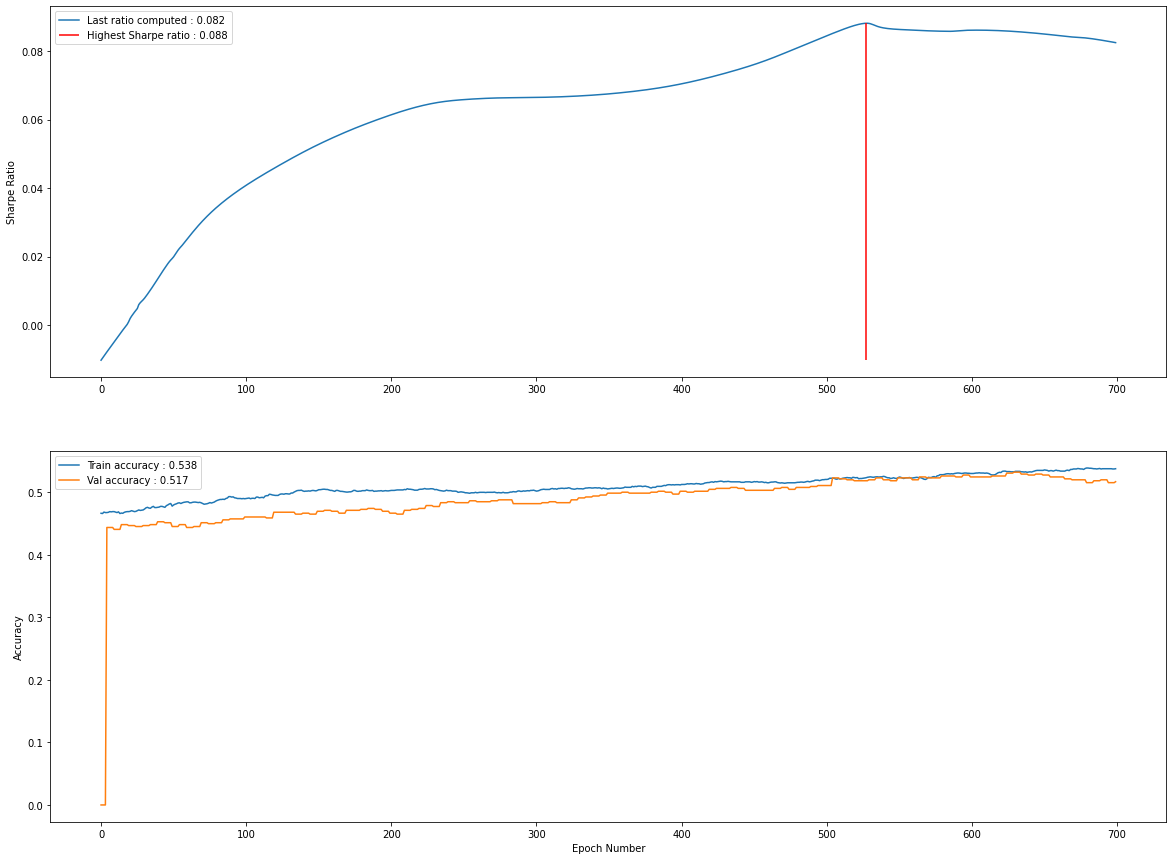

Best Val accuracy : 0.532
At epoch : 629


In [16]:
# Use our function

M = 2  # sequences_number => The sequence number is the number of days given to predict the next. Ex : if M=2, 2 days will be taken to predict the 3rd

best_params, parametres = deep_neural_network(
    x_train,
    y_train,
    x_val,
    y_val,
    x_train_pct_change,
    hidden_layers=(8,), # Choose the number of neurons you want per layer
    learning_rate=0.1,
    epochs=700,
    sequences_number=M)

In [27]:
# Choose which one you give : parametres or best_params ?
params = best_params  # parametres

# parametres are the last parameters that the network calculated
# best_params are the parameters that gave the best accuracy on the validation set

### Comparison of model predictions (long and short) against long trades only on training set

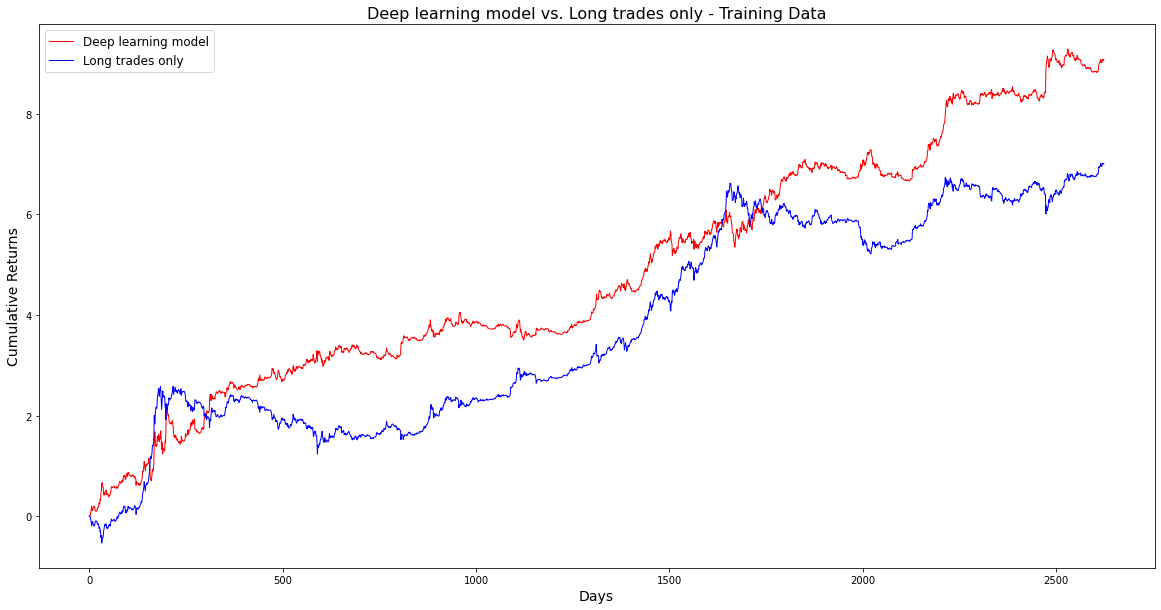

In [28]:
# Prepare y
y_gd = y_train.T
y_gd = np.insert(y_gd, 0, 1) # y for the gradient descent to not have data leakage, 1 by default
y_gd = y_gd.astype(np.float)  # transform elements to float

# Prediction on train set
pred_train = new_prediction(x_train, y_gd, params, M)
pred_train = convert_prediction(pred_train, 0.0001, -0.0001)

# Plot Model vs Only long on training
train_returns = return_pred(pred_train, x_train_pct_change, M)[:-1]
plt.figure(figsize=(20, 10))
plt.plot(train_returns.cumsum(),
         label="Deep learning model",
         linewidth=1,
         color='red')
plt.plot(x_train_pct_change[M:-1, 0].cumsum(),
         label="Long trades only",
         linewidth=1,
         color='blue')
plt.xlabel('Days', size=14)
plt.ylabel('Cumulative Returns', size=14)
plt.legend(prop={'size': 12})
plt.title("Deep learning model vs. Long trades only - Training Data",
          size=16)
plt.show()

In [29]:
# Compare the number of bad and good trade of our model
trades = [
    1 if i > 0 else 0 for i in train_returns if i != 0
]  # we do not take account about 0 because we do nothing if 0 (train_returns is the pct change we traded well or not)
print(
    f'Percentage of good trades on train set : {round(trades.count(1)/len(trades), 3)}%'
)

Percentage of good trades on train set : 0.533%


### Comparison of model predictions (long and short) against long only trades on validation set

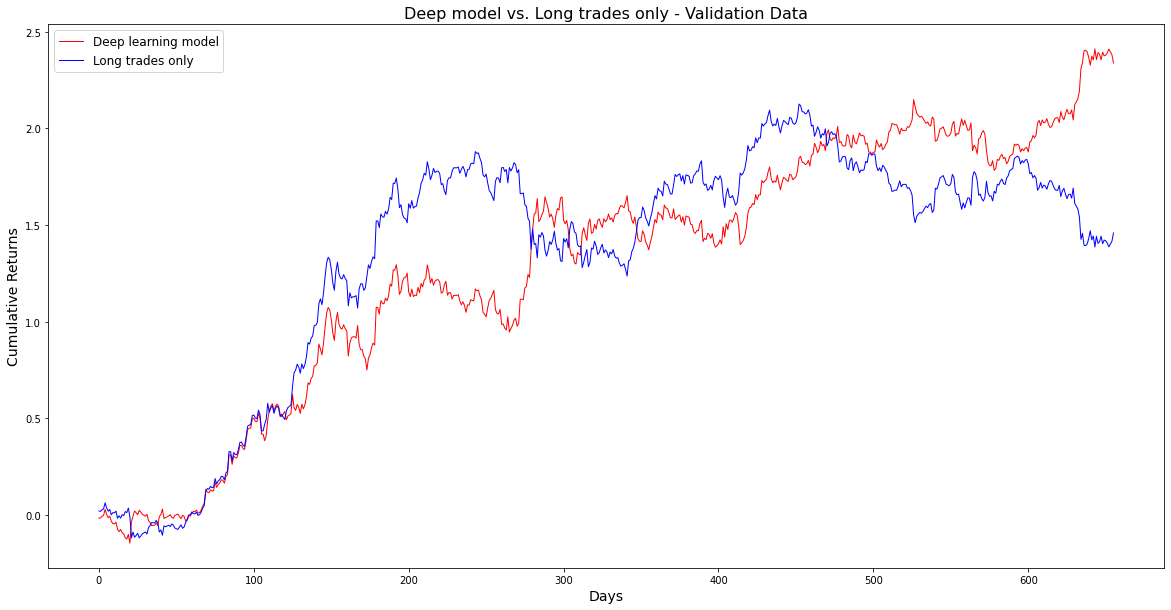

In [30]:
# Prepare y
y_gd = y_val.T
y_gd = np.insert(y_gd, 0, 1) # y for the gradient descent to not have data leakage, 1 by default
y_gd = y_gd.astype(np.float)  # transform elements to float

# Prediction on test set
pred_val = new_prediction(x_val, y_gd, params, M)
pred_val = convert_prediction(pred_val, 0.0001, -0.0001)

# plot Model vs Only long on training
val_returns = return_pred(pred_val, x_val_pct_change, M)
plt.figure(figsize=(20, 10))
plt.plot(val_returns.cumsum(),
         label="Deep learning model",
         linewidth=1,
         color='red')
plt.plot(x_val_pct_change[M:, 0].cumsum(),
         label="Long trades only",
         linewidth=1,
         color='blue')
plt.xlabel('Days', size=14)
plt.ylabel('Cumulative Returns', size=14)
plt.legend(prop={'size': 12})
plt.title("Deep model vs. Long trades only - Validation Data", size=16)
plt.show()

In [31]:
# Compare the number of bad and good trade
trades = [
    1 if i > 0 else 0 for i in val_returns if i != 0
]  # we do not take account about 0 because we do nothing if 0 (train_returns is the pct change we traded well or not)
print(
    f'Percentage of good trades on test set : {round(trades.count(1)/len(trades), 3)}%'
)

Percentage of good trades on test set : 0.532%


##### Final word : we can see that with only pct change, the position of the day and RSI as input our model can already perform better than a strategy based only on the Long.